# CR3BP low-thrust

In this tutorial we show the use of the {class}`pykep.trajopt.direct_cr3bp` to find a low-thrust (zero-order hold continuous thrust) trajectory connecting two orbits in the circular restricted 3-body problem (CR3BP). 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0=0$, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [374]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data. For the purpose of this simple notebook we choose a simple Earth to Mars transfer.

In [375]:
import json
import os

# Id to load
# ID = 0 # Yuri No Mass
# ID = 0, 1, 2, 3, 4, 5, 6, 7 # Laurant No Mass
ID = 3 # 0, 1, 2, 3 # Yuri Mass

results_file = '/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/'
# results_name = f'yuri_mass/id{ID}_sf_nd_const'
# results_name = f'yuri_mass_g/id{ID}_sf_nd_const'
# results_name = f'yuri_mass_free/id{ID}_sf_nd_const'
results_name = f'yuri_mass_free_g/id{ID}_sf_nd_const'

# 1. Create initial folder
folder_name = results_file + results_name
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Load JSON file
# with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances.json", "r") as f:
# with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances_lb.json", "r") as f:
with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances_ys_mass.json", "r") as f:
    data = json.load(f)

# Problem data
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)

# Example masses (you can adjust logic if they differ)
ms = 1.0
mf = 0.5

for k, v in data.items():
    if int(k) == int(ID):
        tof = v["tspan"][1]
        
        # Initial state
        x0 = v["x0"]
        rs = np.array(x0[0:3])
        vs = np.array(x0[3:6])
        period0 = v["period0"]
        
        # Final state
        xf = v["xf"]
        rf = np.array(xf[0:3])
        vf = np.array(xf[3:6])
        periodf = v["periodf"]

        # ISPs
        c1 = v["c1"]
        c2 = v["c2"]
        tspan = [0.0, tof]

# Assign parameters
max_thrust = c1
veff = c2

# Other parameters
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)

# Initial guess
lambda_init = np.array([1]*8)
lambda_init = (np.array(x0) - np.array(xf)).tolist() + [1, 1]

# # Check the Lyapunov compiled function
# lambda_dV_dx = dV_dx_cf(np.hstack([x0, [m0], xf]), pars=[mu])
# lambda_init = lambda_dV_dx.tolist() + [1, 1]

eps = 1e-1
lambda0 = lambda_init[-1]

print('lambda_init: ', lambda_init)

Created folder: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_free_g/id3_sf_nd_const
lambda_init:  [0.26654273978083165, 0.0, -0.11145303634437023, 0.0, -0.6778309185391602, 0.0, 1, 1]


In [376]:
# Throttles and cuts
nseg = 16
nseg_max = 16
cut = 0.6

In [377]:
# Normalise
L = 384400e3
TIME = np.sqrt(L**3 / (pk.MU_EARTH+pk.MU_MOON))
VEL = L / TIME
ACC = VEL / TIME
MASS = ms

print(f'Normalise L {L:.4f} T {TIME:.4f} V {VEL:.4f} M {MASS:.4f}')

# Problem data
# mu already in non-dimensional units
# max_thrust = max_thrust / (MASS * L / TIME**2)
# veff = veff / VEL

# Initial state
ms = ms / MASS
# rs already in non-dimensional units
# vs already in non-dimensional units

# Final state
mf = mf / MASS
# rf already in non-dimensional units
# vf already in non-dimensional units

# tof
# tof = tof / TIME
# tof already in non-dimensional units

Normalise L 384400000.0000 T 375190.2619 V 1024.5468 M 1.0000


Convert final position and velocity into an orbit

In [378]:
posvel0 = [
    rs.tolist(),
    vs.tolist()
]

# Propagate backwards to t0
ta = pk.ta.get_cr3bp(1e-16)
ta.pars[0] = mu
ta.time = tof
ta.state[:6] = rf.tolist() + vf.tolist()

tgrid = np.linspace(tof,0.0,10)
sol = ta.propagate_grid(tgrid)
integration = sol[5]

rf_0 = integration[-1,:3]
vf_0 = integration[-1,3:6]

posvelf = [
    rf_0.tolist(),
    vf_0.tolist()
]

print(f'IC {rf_0} {vf_0} t {ta.time}')
print(f'FC {rf} {vf} {tof}')


IC [ 0.95170684  0.0883385   0.        ] [ 0.39081263  0.18632513  0.        ] t 0.0
FC [ 0.89833535  0.          0.        ] [ 0.          0.47591169  0.        ] 5.0


We here instantiate two different versions of the same UDP (User Defined Problem), with analytical gradients and without. 

For the purpose of this simple notebook we choose a relatively simple Earth to Mars transfer with an initial $V_{\infty}$ of 3 km/s.

In [379]:
ta = pk.ta.get_zero_hold_cr3bp(1e-16)
ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-16)

In [380]:
udp_g = pk.trajopt.direct_nd(
        pls=posvel0,
        plf=posvelf,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        veff=veff,
        # t0_bounds=[0.0, 0.0],
        t0_bounds=[-tof/2, tof/2],
        tof_bounds=[tof,tof],
        mf_bounds=[ms*0.5, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=cut,
        with_gradient=True,
        high_fidelity=True,
        tas = (ta, ta_var)
)

In [381]:
# We need to generste a random chromosomes compatible with the UDP where to test the gradient.
prob_g = pg.problem(udp_g)
pop_g = pg.population(prob_g, 1)

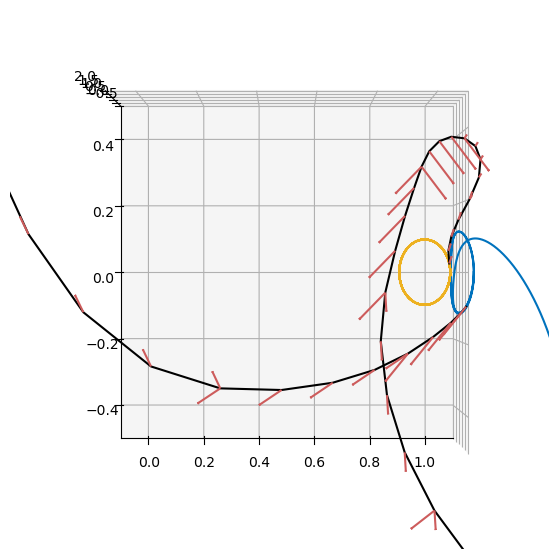

In [382]:
ax = udp_g.plot(pop_g.champion_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)
ax.view_init(90,-90)
# ax.axis('off');

## Analytical performances of the analytical gradient

Compare gradient accuracy

In [383]:
# Check gradientss
# Analytical
an_grad = udp_g.gradient(pop_g.champion_x)
# Numerical
num_grad = pg.estimate_gradient_h(udp_g.fitness, pop_g.champion_x, dx=1e-8)

# Suppose sparsity gives the positions (flat indices in num_grad)
sparsity = udp_g.gradient_sparsity()  # e.g. [0, 3, 10, ...]

# Make an empty dense gradient
dim = int(9+3*nseg)
dense_ana_grad = np.zeros_like(num_grad).reshape(int(len(num_grad)/dim),dim)
num_grad = num_grad.reshape(int(len(num_grad)/dim),dim)

# Fill in analytical entries at the right positions
for jj in range(len(an_grad)):
    dense_ana_grad[sparsity[jj][0], sparsity[jj][1]] = an_grad[jj]
    diff_tmp = abs(dense_ana_grad[sparsity[jj][0], sparsity[jj][1]] - num_grad[sparsity[jj][0], sparsity[jj][1]])
    if diff_tmp > 1e-3:
        print('sparsity[jj]',sparsity[jj] , 'analytical', dense_ana_grad[sparsity[jj][0], sparsity[jj][1]],'numerical', num_grad[sparsity[jj][0], sparsity[jj][1]],'diff',diff_tmp)
# dense_ana_grad = dense_ana_grad.reshape(-1)
# num_grad = num_grad.reshape(-1)

# Now you can compare
diff_bool = np.allclose(num_grad, dense_ana_grad, atol=1e-3, rtol=1e-3)
diff = num_grad - dense_ana_grad
# print('Analytical', dense_ana_grad)
# print('Numerical', num_grad)
print('diff_bool', diff_bool)
print('shape(diff)', np.shape(diff))
print("‖diff‖:", np.linalg.norm(diff))

diff_bool True
shape(diff) (26, 57)
‖diff‖: 3.25800898186e-06


The analytical gradient its exact and faster, seems like a no brainer to use it. 

In reality, the effects on the optimization technique used are not straightforward, making the option to use numerical gradients still interesting in some, albeit rare, cases.

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

:::{note}
This tolerance has a different role from the numerical tolerance set in the particular algorithm chosen to solve the problem and is only used by the *pagmo* machinery to decide outside the optimizer whether the new proposed indivdual is better than what was the previous *champion*.

In [384]:
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6

... and we define an optimization algorithm.

In [385]:
snopt72 = "/Users/harry.holt/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)

algo = pg.algorithm(uda)

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

In [386]:
nseg_old = nseg

# Now convert to a higher number of segments

(-0.5, 0.5)

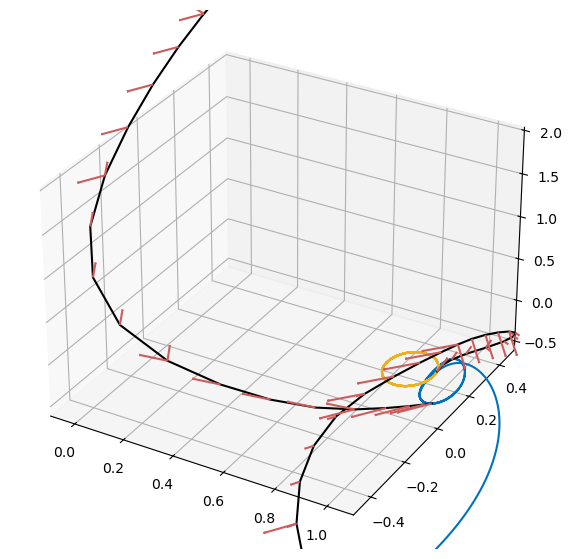

In [387]:
ax = udp_g.plot(pop_g.champion_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)

In [388]:
x_init = pop_g.champion_x

In [389]:
nseg = nseg_old
nseg_old_solved = False

while nseg <= nseg_max:

    # Update UDP
    udp_g.nseg = nseg

    prob_g = pg.problem(udp_g)
    prob_g.c_tol = 1e-6

    if nseg != nseg_old:
        throttles_old = best_x[8:-1]
        throttles_init = [0.0] * (nseg * 3)
        for nn in range(nseg_old):
            throttles_init[nn*6:nn*6+3] = throttles_old[nn*3:nn*3+3]
            throttles_init[nn*6+3:nn*6+6] = throttles_old[nn*3:nn*3+3]
        x_init = best_x[0:8].tolist() + throttles_init + [best_x[-1].item()]
        # x_init = np.array(x_init, dtype=float).tolist()

    print('--------------------------')
    print(f'Testing Nseg {nseg}')
    total_time = 0.0

    ntotal = 20
    errs = []
    obj = []
    xs = []
    successes = []
    average_time = []

    for i in range(ntotal):
        time_start = time.time()
        
        if nseg != nseg_old and nseg_old_solved and i==0:
            pop_g = pg.population(prob_g, 0)
            pop_g.push_back(x_init)
        else:
            pop_g = pg.population(prob_g, 1)
        
        pop_g = algo.evolve(pop_g)
        
        time_end = time.time()
        average_time.append(time_end - time_start)
        total_time += time_end - time_start

        # print('err', np.linalg.norm(pop_g.champion_f[1:]), np.linalg.norm(pop_g.champion_f[1:4]), np.linalg.norm(pop_g.champion_f[4:7]))
        if(prob_g.feasibility_f(pop_g.champion_f)):
            print(".", end="")
            obj.append(pop_g.champion_x[1])
            xs.append(pop_g.champion_x)
            successes.append(1)
            # if nseg != nseg_old:
            #     break
        else:
            print("x", end ="")

    if len(obj)>0:
        print("\nBest mass is: ", np.max(obj))
        print(f"Total time to success: {total_time:.3f} seconds")
        print(f"mean time {np.mean(np.array(average_time)):.4g} s")
        print(f"median time {np.median(np.array(average_time)):.4g} s")
        print(f"std time {np.std(np.array(average_time)):.4g} s")
        best_idx = np.argmax(obj)
        nseg_old_solved = True
    else:
        xs = [pop_g.champion_x]
        best_idx = 0
        successes.append(0)
        obj.append(np.nan)
        print("\nNo solution found")
        nseg_old_solved = False

    best_x = xs[best_idx]

    # Update number of segments
    nseg_old = nseg
    if nseg < nseg_max:
        nseg = nseg * 2
    else:
        break

--------------------------
Testing Nseg 16
...........xx.......
Best mass is:  0.968979593394
Total time to success: 133.127 seconds
mean time 6.656 s
median time 5.211 s
std time 5.025 s


In [390]:
if len(obj)==0:
    xxx

And we plot the trajectory found:

In [391]:
nseg = len(best_x[8:-1]) // 3
udp_g.pretty(best_x)


Low-thrust NEP transfer
Departure: [[1.1648780946517576, 0.0, -0.11145303634437023], [0.0, -0.20191923237095796, 0.0]]
Arrival: [[0.9517068403301521, 0.08833849525618821, 0.0], [0.39081262748026147, 0.18632512529205011, 0.0]]

Launch epoch: -1.44026
Arrival epoch: 3.55974
Time of flight (-): 5.00000 

Launch DV (-) 0.00000000 - [0.0,0.0,0.0]
Arrival DV (-) 0.00000000 - [0.0,0.0,0.0]
Final mass (mf/m0): 0.9689795933935409

Details on the low-thrust leg: (NEEDS fixing) 
Number of segments: 16
Number of fwd segments: 9
Number of bck segments: 7
Maximum thrust: 3.7637494800142672
Central body gravitational parameter: 0.01215058439470971
Specific impulse: 11.56499372183432

Time of flight: 5
Initial mass: 1
Final mass: 0.9689795933935409
State at departure: [[1.0817724592736273, 0.057338848929663434, 0.05342473566225434], [0.01807771753022731, 0.24006322628587126, -0.11073864765696767]]
State at arrival: [[0.9161358712696697, -0.05778324550552174, 0], [-0.26016369482894264, 0.3756472040538

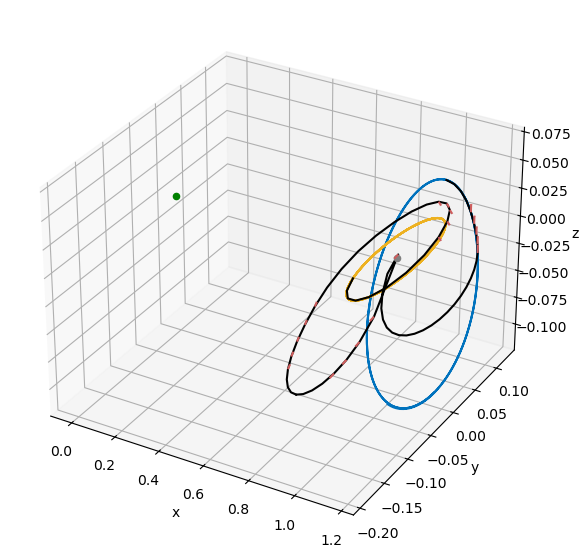

In [392]:
ax = udp_g.plot(best_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
# ax.set_xlim(-0.1,1.1)
# ax.set_ylim(-1/2,1/2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(90,-90)
# ax.axis('off');

plt.savefig(os.path.join(folder_name, "trajectory.png"))


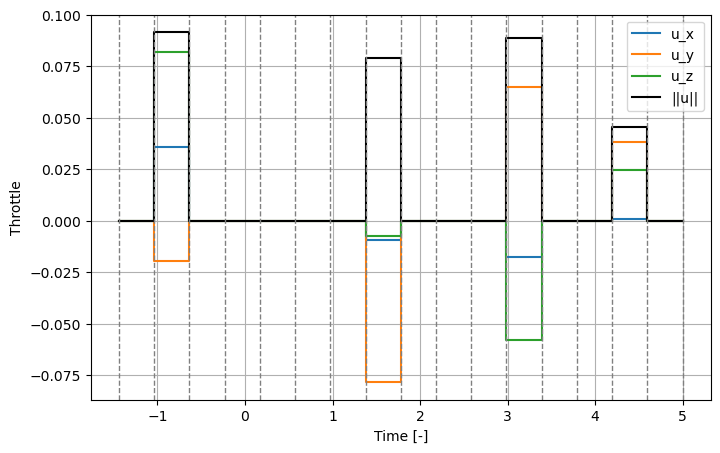

In [393]:
# Extract throttle values from the best solution
tgrid = np.linspace(best_x[0], best_x[-1], int(len(best_x[8:-1])/3)+1)
throttle_profile = best_x[8:-1].reshape(int(len(best_x[8:-1])/3), 3)
# throttle_profile_ones = np.ones_like(throttle_profile)

# Objective: integral of the thrust
# obj = np.trapezoid(np.linalg.norm(throttle_profile[:, 0:3],axis=1),tgrid)/(tgrid[-1]-tgrid[0])
# obj = np.sum(np.linalg.norm(throttle_profile[:, 0:3],axis=1) * np.diff(tgrid)) / (tgrid[-1]-tgrid[0])

fig, ax = plt.subplots(figsize=(8, 5))

# Plot thrust profiles
ax.step(tgrid, np.hstack((throttle_profile[:, 0], throttle_profile[-1, 0])), label='u_x', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 1], throttle_profile[-1, 1])), label='u_y', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 2], throttle_profile[-1, 2])), label='u_z', where='post')
ax.step(
    tgrid,
    np.hstack((
        np.linalg.norm(throttle_profile[:, 0:3], axis=1),
        np.linalg.norm(throttle_profile[-1, 0:3])
    )),
    color='k', label='||u||', where='post'
)

# Add vertical grid lines
for t in tgrid:
    ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.0)

# Labels, legend, and grid
ax.set_xlabel('Time [-]')
ax.set_ylabel('Throttle')
# ax.set_title(f'Thrust Profile: Obj {obj:.4f}')
ax.legend()
ax.grid(True)

# Save and show
plt.savefig(os.path.join(folder_name, "control.png"))
plt.show()


In [394]:
import io
import sys

# Redirect stdout to capture udp_g.pretty(best_x) output
text_path = os.path.join(folder_name, "output.txt")
buffer = io.StringIO()
sys_stdout_backup = sys.stdout  # Backup real stdout
sys.stdout = buffer

try:
    udp_g.pretty(best_x)
finally:
    # Restore stdout
    sys.stdout = sys_stdout_backup

# Write captured output to file
output_text = buffer.getvalue()
with open(text_path, "w") as f:
    f.write(output_text)
print(f"Saved udp_g.pretty(best_x) output to: {text_path}")

Saved udp_g.pretty(best_x) output to: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_free_g/id3_sf_nd_const/output.txt


In [395]:
import shutil
# === Rename folder at the end ===
final_folder_name = f"{folder_name}_n{nseg:.0f}_o{best_x[1]:.4f}"
if not os.path.exists(final_folder_name):
    shutil.move(folder_name, final_folder_name)
print(f"Renamed folder to: {final_folder_name}")

Renamed folder to: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_free_g/id3_sf_nd_const_n16_o0.9690
